In [120]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision import transforms, models
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
import csv
import re
from collections import Counter
from sklearn.model_selection import train_test_split
import random

In [3]:
# Read CSV
df = pd.read_csv('dogs.csv')

data_dir = '.'

# Split data into train, validation, and test
train_df = df[df['data set'] == 'train']
val_df = df[df['data set'] == 'val']
test_df = df[df['data set'] == 'test']

# Define transformations
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create DataLoaders
batch_size = 32
train_dataset = datasets.ImageFolder(root=os.path.join(data_dir, "train"), transform=train_transform)
valid_dataset = datasets.ImageFolder(root=os.path.join(data_dir, "valid"), transform=val_test_transform)
test_dataset = datasets.ImageFolder(root=os.path.join(data_dir, "test"), transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [2.7418136649970393e-09..1.0000000236034394].


Label: Blenheim


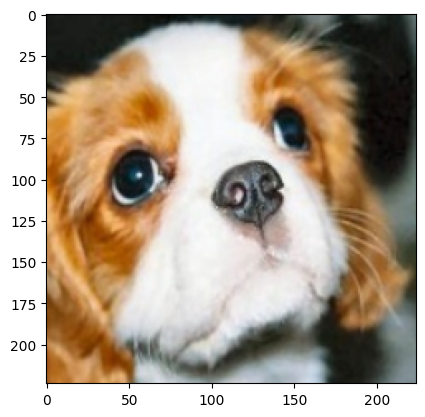

In [34]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    plt.imshow(inp)
    
images, labels = next(iter(train_loader))
imshow(images[0])
print(f"Label: {train_dataset.classes[labels[0]]}")

In [6]:
class DogBreedCNN(nn.Module):
    def __init__(self, num_classes=70):
        super(DogBreedCNN, self).__init__()
        self.features = nn.Sequential(
            #Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),  # RGB input has 3 channels
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 224->112
            
            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 112->56
            
            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 56->28
            
            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 28->14
            
            # Block 5
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 14->7
        )
        
        # Classifier head
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x
# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DogBreedCNN(num_classes=70).to(device)

In [36]:
test_input = torch.randn(2, 3, 224, 224)  # batch_size=2
output = model(test_input.to(device))
print(f"Output shape: {output.shape}")  # Should be (2, 70)
print(f"Output values: {output}")

Output shape: torch.Size([2, 70])
Output values: tensor([[-0.0487,  0.1528,  0.4727,  0.1684, -0.2440,  0.3782, -0.0090, -0.5971,
         -0.3475,  0.1570, -0.1710, -0.1923, -0.1787, -0.0361,  0.2267,  0.2304,
          0.0552, -0.0370,  0.5325, -0.1677, -0.1941, -0.3964, -0.0880, -0.1963,
         -0.1522, -0.0473, -0.3573, -0.3573,  0.4084,  0.3060,  0.3062, -0.1371,
         -0.0392, -0.0889,  0.0705, -0.1827, -0.1259,  0.0086, -0.0017, -0.0532,
         -0.0873, -0.1418, -0.3068, -0.0022,  0.3896, -0.3131,  0.1516, -0.3586,
          0.2490, -0.2355,  0.3606, -0.3928, -0.1236,  0.0977, -0.0703, -0.0208,
         -0.0494, -0.2871,  0.1518,  0.0487,  0.1394,  0.3648,  0.0015, -0.1696,
         -0.1090, -0.3918, -0.2206,  0.1009,  0.0506, -0.1754],
        [ 0.0463,  0.1390, -0.0645,  0.0509, -0.0913,  0.3467, -0.0755, -0.2280,
          0.0471, -0.0533, -0.0732,  0.2224,  0.0566,  0.0442, -0.2345,  0.2206,
          0.0418, -0.2569,  0.3654,  0.0446,  0.1290,  0.3064,  0.3407,  0.16

In [6]:
# 1. Initialize datasets FIRST
train_dataset = datasets.ImageFolder(
    root=os.path.join(data_dir, "train"),
    transform=train_transform
)

# 2. THEN verify dataset properties
print(f"Total training samples: {len(train_dataset)}")  # Should be >>70
print(f"Number of classes: {len(train_dataset.classes)}")  # Must be 70
print(f"Class mapping:\n{train_dataset.class_to_idx}")  # Verify all classes

# 3. Check batch labels
sample_batch = next(iter(train_loader))
print(f"Batch labels shape: {sample_batch[1].shape}")
print(f"Unique labels in batch: {torch.unique(sample_batch[1], return_counts=True)}")

Total training samples: 7946
Number of classes: 70
Class mapping:
{'Afghan': 0, 'African Wild Dog': 1, 'Airedale': 2, 'American Hairless': 3, 'American Spaniel': 4, 'Basenji': 5, 'Basset': 6, 'Beagle': 7, 'Bearded Collie': 8, 'Bermaise': 9, 'Bichon Frise': 10, 'Blenheim': 11, 'Bloodhound': 12, 'Bluetick': 13, 'Border Collie': 14, 'Borzoi': 15, 'Boston Terrier': 16, 'Boxer': 17, 'Bull Mastiff': 18, 'Bull Terrier': 19, 'Bulldog': 20, 'Cairn': 21, 'Chihuahua': 22, 'Chinese Crested': 23, 'Chow': 24, 'Clumber': 25, 'Cockapoo': 26, 'Cocker': 27, 'Collie': 28, 'Corgi': 29, 'Coyote': 30, 'Dalmation': 31, 'Dhole': 32, 'Dingo': 33, 'Doberman': 34, 'Elk Hound': 35, 'French Bulldog': 36, 'German Sheperd': 37, 'Golden Retriever': 38, 'Great Dane': 39, 'Great Perenees': 40, 'Greyhound': 41, 'Groenendael': 42, 'Irish Spaniel': 43, 'Irish Wolfhound': 44, 'Japanese Spaniel': 45, 'Komondor': 46, 'Labradoodle': 47, 'Labrador': 48, 'Lhasa': 49, 'Malinois': 50, 'Maltese': 51, 'Mex Hairless': 52, 'Newfoundl

In [24]:
num_epochs = 20 # Let's train for total 100 epochs

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-3,            # Initial learning rate
    weight_decay=0.01   # Weight decay for regularization
)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1e-3,                          # Peak learning rate
    steps_per_epoch=len(train_loader),
    epochs=num_epochs,
    pct_start=0.3                         # % of training spent increasing LR
)

In [25]:
for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(train_dataset)
    
    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss = val_loss / len(valid_dataset)
    val_acc = correct / total
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {epoch_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

Epoch 1/20
Train Loss: 1.2490 | Val Loss: 1.2477 | Val Acc: 0.7414
Epoch 2/20
Train Loss: 1.2475 | Val Loss: 1.0985 | Val Acc: 0.7900
Epoch 3/20
Train Loss: 1.2470 | Val Loss: 1.1373 | Val Acc: 0.7714
Epoch 4/20
Train Loss: 1.2062 | Val Loss: 1.2106 | Val Acc: 0.7586
Epoch 5/20
Train Loss: 1.2006 | Val Loss: 1.0987 | Val Acc: 0.7914
Epoch 6/20
Train Loss: 1.2104 | Val Loss: 1.1062 | Val Acc: 0.7886
Epoch 7/20
Train Loss: 1.1679 | Val Loss: 1.0848 | Val Acc: 0.7971
Epoch 8/20
Train Loss: 1.1859 | Val Loss: 1.1839 | Val Acc: 0.7686
Epoch 9/20
Train Loss: 1.1709 | Val Loss: 1.1056 | Val Acc: 0.8000
Epoch 10/20
Train Loss: 1.1541 | Val Loss: 1.2653 | Val Acc: 0.7700
Epoch 11/20
Train Loss: 1.1755 | Val Loss: 1.0329 | Val Acc: 0.8143
Epoch 12/20
Train Loss: 1.1475 | Val Loss: 1.1983 | Val Acc: 0.8000
Epoch 13/20
Train Loss: 1.1648 | Val Loss: 1.0079 | Val Acc: 0.8186
Epoch 14/20
Train Loss: 1.1311 | Val Loss: 1.0876 | Val Acc: 0.7929
Epoch 15/20
Train Loss: 1.0885 | Val Loss: 1.1254 | Val A

In [26]:
torch.save(model.state_dict(), 'dog_breed_cnn_2.pth')

In [38]:
model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_acc = test_correct / test_total
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.8014


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


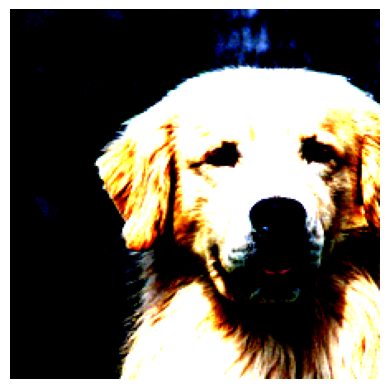

Predicted class: Saint Bernard


In [50]:
golden_test = Image.open('golden_test.png')
golden_test = val_test_transform(golden_test)
plt.imshow(golden_test.numpy().transpose((1, 2, 0)))
plt.axis('off')
plt.show()
golden_test = golden_test.unsqueeze(0).to(device)
outputs = model(golden_test)
_, predicted = torch.max(outputs.data, 1)
print(f"Predicted class: {train_dataset.classes[predicted.item()]}")

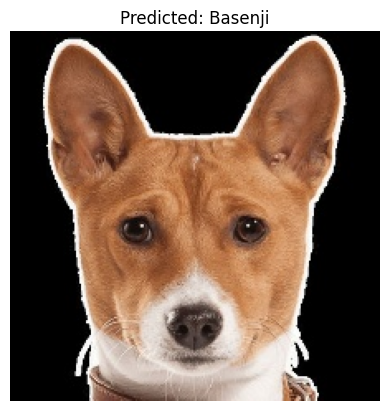

In [28]:
def predict_single_image(image_path, model, transform):
    model.eval()
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(input_tensor)
        predicted_class = output.argmax(1).item()

    # Hiển thị ảnh và nhãn dự đoán
    plt.imshow(image)
    plt.title(f"Predicted: {train_dataset.classes[predicted_class]}")
    plt.axis("off")
    plt.show()

# Ví dụ sử dụng (cần thay đổi đường dẫn ảnh tùy theo dữ liệu của bạn)
predict_single_image("./test/Basenji/10.jpg", model, val_test_transform)

In [49]:
model = DogBreedCNN(num_classes=70).to(device)
model.load_state_dict(torch.load('dog_breed_cnn_2.pth'))

<All keys matched successfully>

In [174]:
# Create properly initialized vocabulary with special tokens
vocab = {
    '<PAD>': 0,
    '<UNK>': 1,
    '<SOS>': 2,
    '<EOS>': 3
}

qa_df = pd.read_csv('Final_Original_Names_Dog_Breed_QA_Dataset.csv')

# Add other words from dataset
word_idx = 4
for question, answer in qa_df[['Question', 'Answer']].values:
    for word in question.lower().split():
        if word not in vocab:
            vocab[word] = word_idx
            word_idx += 1
    
    for word in answer.lower().split():
        if word not in vocab:
            vocab[word] = word_idx
            word_idx += 1

In [14]:
# Load the CSV file
file_path = 'Final_Original_Names_Dog_Breed_QA_Dataset.csv'
df = pd.read_csv(file_path)

# Check the first few rows
print(df.head())

# Get basic information
print(f"Total rows: {len(df)}")
print(f"Unique breeds: {df['Breed'].nunique()}")
print(f"Questions per breed: {df.groupby('Breed').size().mean():.1f}")

    Breed                                           Question  \
0  Afghan    How does the gait or movement of a Afghan look?   
1  Afghan  How would you describe the ear shape of a Afghan?   
2  Afghan  How does the body structure of a Afghan compar...   
3  Afghan  What kind of fur texture is typical for a Afghan?   
4  Afghan  Does the Afghan breed have any specific eye sh...   

                                              Answer  
0  The afghan has a elegant and smooth gait, allo...  
1     The afghan typically has long and droopy ears.  
2          The afghan has a compact and sturdy body.  
3  The afghan has a long and silky coat, which is...  
4  An afghan can be recognized by its large, roun...  
Total rows: 1398
Unique breeds: 70
Questions per breed: 20.0


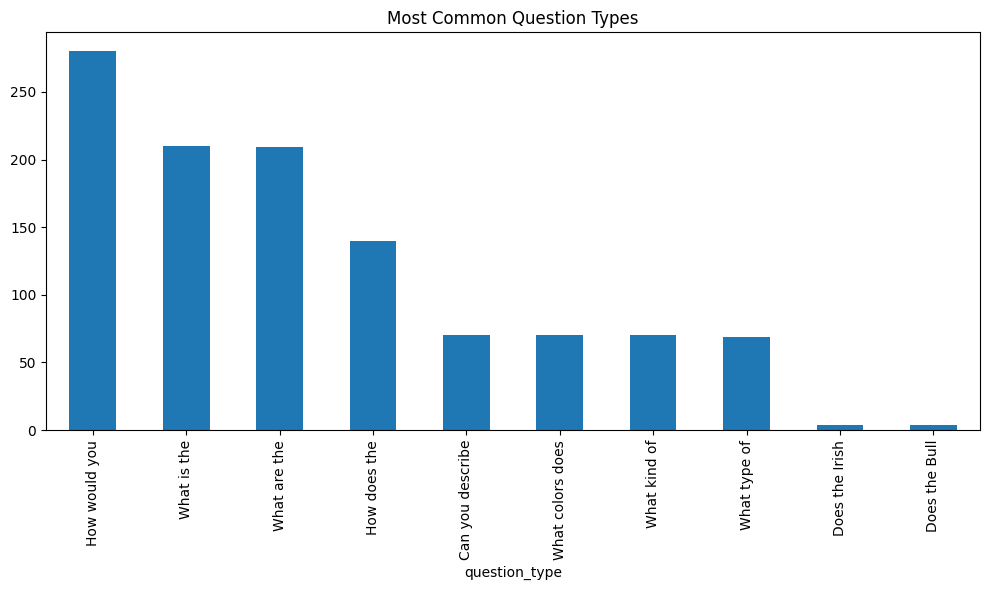

In [31]:
# Simple analysis of question types
import matplotlib.pyplot as plt

# Extract first 3 words from questions to categorize them
df['question_type'] = df['Question'].str.split().str[:3].str.join(' ')
question_counts = df['question_type'].value_counts().head(10)

plt.figure(figsize=(10, 6))
question_counts.plot(kind='bar')
plt.title('Most Common Question Types')
plt.tight_layout()
plt.savefig('question_types.png')

In [91]:
def generate_vqa_dataset(image_dir, qa_csv_file, output_dir):
    # Load question-answer pairs
    qa_data = pd.read_csv(qa_csv_file)
    qa_by_breed = qa_data.groupby('Breed')
    
    # Create dictionary mapping breed to list of image paths
    breed_to_images = {}
    for breed in os.listdir(image_dir):
        breed_path = os.path.join(image_dir, breed)
        if os.path.isdir(breed_path):
            image_files = [os.path.join(breed_path, f) for f in os.listdir(breed_path) 
                          if f.endswith(('.jpg', '.png', '.jpeg'))]
            breed_to_images[breed] = image_files
    
    # Generate combinations for each breed
    vqa_pairs = []
    for breed, group in qa_by_breed:
        if breed in breed_to_images:
            images = breed_to_images[breed]
            qa_pairs = group[['Question', 'Answer']].values.tolist()
            
            # For each image of this breed, pair with each QA
            for img_path in images:
                for question, answer in qa_pairs:
                    vqa_pairs.append({
                        'breed': breed,
                        'image_path': img_path,
                        'question': question,
                        'answer': answer
                    })
    
    # Save dataset
    pd.DataFrame(vqa_pairs).to_csv(os.path.join(output_dir, 'vqa_dataset.csv'), index=False)
    return vqa_pairs

# Generate VQA dataset
vqa_pairs = generate_vqa_dataset('train', 'Final_Original_Names_Dog_Breed_QA_Dataset.csv', 'data')

In [112]:
class DogBreedVQADataset(Dataset):
    def __init__(self, qa_pairs,vocab, transform=None):
        self.qa_pairs = qa_pairs  # (question, answer) tuples
        self.transform = transform
        self.vocab = vocab
        
    def __len__(self):
        return len(self.qa_pairs)
        
    def __getitem__(self, idx):
        breed, img_path, question, answer = self.qa_pairs[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return {
            'image': image,
            'question': self.tokenize(question),
            'answer': self.tokenize(answer),
            'breed': breed
        }
        
    def tokenize(self,string):
        # Add special tokens
        tokens = ['<SOS>'] + string.lower().split() + ['<EOS>']
        # Convert to indices and handle unknown words
        return torch.tensor([self.vocab.get(word, self.vocab['<UNK>']) for word in tokens])

In [51]:
class Attention(nn.Module):
    def __init__(self, image_dim, question_dim, attention_dim=512):
        super(Attention, self).__init__()
        
        # Project both image and question features to the same attention space
        self.image_projection = nn.Linear(image_dim, attention_dim)
        self.question_projection = nn.Linear(question_dim, attention_dim)
        
        # Attention vector for computing weights
        self.attention_vector = nn.Linear(attention_dim, 1)
        
    def forward(self, image_features, question_features):
        # image_features: [batch_size, num_regions, image_dim]
        # question_features: [batch_size, question_dim]
        
        batch_size = image_features.size(0)
        num_regions = image_features.size(1)
        
        # Expand question features to match spatial regions of image
        question_features = question_features.unsqueeze(1).repeat(1, num_regions, 1)
        
        # Project to common attention space
        img_proj = self.image_projection(image_features)  # [batch, regions, attention_dim]
        ques_proj = self.question_projection(question_features)  # [batch, regions, attention_dim]
        
        # Joint attention features
        joint_features = torch.tanh(img_proj + ques_proj)  # [batch, regions, attention_dim]
        
        # Calculate attention scores
        attention_scores = self.attention_vector(joint_features).squeeze(-1)  # [batch, regions]
        
        # Apply softmax to get attention weights
        attention_weights = F.softmax(attention_scores, dim=1)  # [batch, regions]
        
        # Apply attention weights to get context vector
        context = torch.sum(attention_weights.unsqueeze(-1) * image_features, dim=1)  # [batch, image_dim]
        
        return context, attention_weights


In [152]:
class VQAModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim=300, hidden_dim=512, pretrained=False):
        super(VQAModel, self).__init__()
        
        self.vocab_size = vocab_size
        # Special tokens - ensure these match your vocabulary
        self.sos_idx = 2  # <SOS> token
        self.eos_idx = 3  # <EOS> token
        self.pad_idx = 0  # <PAD> token
        
        # Image encoder - Using ResNet
        self.cnn = models.resnet18(pretrained=pretrained)
        
        # Question encoder components
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.question_encoder = nn.LSTM(
            embedding_dim, 
            hidden_dim, 
            batch_first=True,
            bidirectional=True
        )
        self.question_projection = nn.Linear(hidden_dim*2, hidden_dim)
        
        # Attention mechanism
        self.attention = Attention(512, hidden_dim)
        
        # Encoder fusion layer
        self.encoder_fusion = nn.Sequential(
            nn.Linear(512 + hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        
        # Decoder for answer generation
        self.decoder = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        
        # Output projection
        self.output_projection = nn.Linear(hidden_dim, vocab_size)
    
    def encode(self, image, question, question_lengths):
        # Process image through CNN layers
        x = self.cnn.conv1(image)
        x = self.cnn.bn1(x)
        x = self.cnn.relu(x)
        x = self.cnn.maxpool(x)

        x = self.cnn.layer1(x)
        x = self.cnn.layer2(x)
        x = self.cnn.layer3(x)
        img_features = self.cnn.layer4(x)  # [batch, 512, 7, 7]
        
        # Reshape for attention
        batch_size = img_features.size(0)
        img_features = img_features.view(batch_size, 512, -1).permute(0, 2, 1)  # [batch, 49, 512]
        
        # Process question
        embedded = self.embedding(question)
        packed = nn.utils.rnn.pack_padded_sequence(
            embedded, question_lengths, batch_first=True, enforce_sorted=False
        )
        _, (hidden, cell) = self.question_encoder(packed)
        
        # Combine bidirectional outputs
        question_features = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        question_features = self.question_projection(question_features)
        
        # Apply attention
        context, _ = self.attention(img_features, question_features)
        
        # Create thought vector by fusing features
        thought_vector = self.encoder_fusion(torch.cat((context, question_features), dim=1))
        
        return thought_vector, cell[-1]
    
    def forward(self, image, question, question_lengths, answer=None, teacher_forcing_ratio=0.5):
        batch_size = image.size(0)
        
        # Encode image and question
        thought_vector, memory_cell = self.encode(image, question, question_lengths)
        
        # Prepare for decoding
        target_length = answer.size(1) if answer is not None else 20
        outputs = torch.zeros(batch_size, target_length, self.vocab_size, device=image.device)
        
        # Initialize decoder input with <SOS> token
        decoder_input = torch.full((batch_size, 1), self.sos_idx, 
                                  dtype=torch.long, device=image.device)
        
        # Set initial hidden state with encoded thought vector
        decoder_hidden = (thought_vector.unsqueeze(0), 
                          memory_cell.unsqueeze(0))
        
        # Generate answer sequence
        for t in range(target_length):
            # Get embedding of current input token
            decoder_emb = self.embedding(decoder_input)
            
            # Run through decoder LSTM
            decoder_output, decoder_hidden = self.decoder(decoder_emb, decoder_hidden)
            
            # Project to vocabulary
            prediction = self.output_projection(decoder_output.squeeze(1))
            outputs[:, t] = prediction
            
            # Determine next input: teacher forcing or own prediction
            use_teacher_forcing = random.random() < teacher_forcing_ratio and answer is not None
            
            if use_teacher_forcing:
                decoder_input = answer[:, t].unsqueeze(1)
            else:
                _, top_indices = prediction.topk(1)
                decoder_input = top_indices
                
                # Check if all sequences have generated <EOS>
                if all(decoder_input.eq(self.eos_idx).view(-1)):
                    break
                    
        return outputs
    
    def generate_answer(self, image, question, question_lengths, max_length=20):
        batch_size = image.size(0)
        
        # Encode image and question
        thought_vector, memory_cell = self.encode(image, question, question_lengths)
        
        # Initialize decoder input with <SOS> token
        decoder_input = torch.full((batch_size, 1), self.sos_idx, 
                                  dtype=torch.long, device=image.device)
        
        # Set initial hidden state with encoded thought vector
        decoder_hidden = (thought_vector.unsqueeze(0), 
                          memory_cell.unsqueeze(0))
        
        # Store generated tokens
        generated_tokens = []
        
        # Generate sequence
        for _ in range(max_length):
            decoder_emb = self.embedding(decoder_input)
            decoder_output, decoder_hidden = self.decoder(decoder_emb, decoder_hidden)
            prediction = self.output_projection(decoder_output.squeeze(1))
            
            # Get most likely next token
            _, top_indices = prediction.topk(1)
            token = top_indices.item()
            generated_tokens.append(token)
            
            # Break if <EOS> generated
            if token == self.eos_idx:
                break
                
            # Next input is current prediction
            decoder_input = top_indices
            
        return generated_tokens


In [145]:
def collate_fn(batch):
    # Sort by question length (important for packed sequence processing)
    batch = sorted(batch, key=lambda x: len(x['question']), reverse=True)
    
    # Stack all images into a single tensor
    images = torch.stack([item['image'] for item in batch])
    
    # Get question sequences and their actual lengths (needed for packing)
    questions = [item['question'] for item in batch]
    question_lengths = torch.tensor([len(q) for q in questions])
    
    # Get answer sequences
    answers = [item['answer'] for item in batch]
    
    # Pad sequences to same length within batch
    padded_questions = nn.utils.rnn.pad_sequence(questions, batch_first=True)
    padded_answers = nn.utils.rnn.pad_sequence(answers, batch_first=True)
    
    # Keep original data for reference
    breeds = [item['breed'] for item in batch]
    
    return {
        'image': images,
        'question': padded_questions,
        'question_lengths': question_lengths,
        'answer': padded_answers,
        'breed': breeds
    }


In [166]:
def evaluate(model, dataloader, criterion, device, vocab=None, print_samples=5):
    model.eval()
    total_loss = 0
    
    # For BLEU score calculation
    all_references = []
    all_hypotheses = []
    
    # Create index-to-word mapping for readable output
    if vocab:
        idx_to_word = {idx: word for word, idx in vocab.items()}
    
    # Track number of samples to display
    samples_shown = 0
    
    with torch.no_grad():
        for batch in dataloader:
            images = batch['image'].to(device)
            questions = batch['question'].to(device)
            question_lengths = batch['question_lengths']
            answers = batch['answer'].to(device)
            
            # Forward pass (teacher forcing = 0 for evaluation)
            outputs = model(images, questions, question_lengths, answers, teacher_forcing_ratio=0)
            
            # Handle loss calculation
            outputs = outputs[:, :-1, :]  # Remove last prediction
            outputs_flat = outputs.reshape(-1, outputs.size(-1))
            answers_flat = answers[:, 1:].contiguous().view(-1)  # Remove <SOS>
            
            loss = criterion(outputs_flat, answers_flat)
            total_loss += loss.item()
            
            # Get readable predictions for some samples
            if vocab and samples_shown < print_samples:
                # Get argmax for each position in sequence
                output_sequences = outputs.argmax(dim=2)  # [batch, seq_len]
                
                # Print some samples
                for i in range(min(3, output_sequences.size(0))):
                    # Convert question tokens to words
                    q_tokens = questions[i].cpu().numpy()
                    q_words = [idx_to_word.get(idx.item(), '<UNK>') for idx in questions[i]]
                    q_text = ' '.join([w for w in q_words if w not in ['<PAD>', '<SOS>', '<EOS>']])
                    
                    # Convert target answer tokens to words
                    a_tokens = answers[i].cpu().numpy()
                    a_words = [idx_to_word.get(idx.item(), '<UNK>') for idx in answers[i]]
                    a_text = ' '.join([w for w in a_words if w not in ['<PAD>', '<SOS>', '<EOS>']])
                    
                    # Convert predicted answer tokens to words
                    p_tokens = output_sequences[i].cpu().numpy()
                    p_words = []
                    for idx in p_tokens:
                        word = idx_to_word.get(idx, '<UNK>')
                        if word == '<EOS>':
                            break
                        if word not in ['<PAD>', '<SOS>']:
                            p_words.append(word)
                    p_text = ' '.join(p_words)
                    
                    print(f"Question: {q_text}")
                    print(f"Target: {a_text}")
                    print(f"Predicted: {p_text}")
                    print("-" * 50)
                
                samples_shown += 1
            
            # Add to lists for BLEU calculation
            output_sequences = outputs.argmax(dim=2).cpu().numpy()
            
            for i in range(answers.size(0)):
                # Get target tokens (excluding special tokens)
                target_seq = []
                for idx in answers[i].cpu().numpy():
                    if idx != vocab['<PAD>'] and idx != vocab['<SOS>'] and idx != vocab['<EOS>']:
                        target_seq.append(idx_to_word.get(idx, '<UNK>'))
                
                # Get predicted tokens (excluding special tokens, stopping at EOS)
                pred_seq = []
                for idx in output_sequences[i]:
                    word = idx_to_word.get(idx, '<UNK>')
                    if word == '<EOS>':
                        break
                    if word != '<PAD>' and word != '<SOS>':
                        pred_seq.append(word)
                
                all_references.append([target_seq])
                all_hypotheses.append(pred_seq)
    return total_loss / len(dataloader)


In [162]:
def train_epoch(model, dataloader, optimizer,scheduler, device, teacher_forcing_ratio=0.5):
    model.train()
    total_loss = 0
    criterion = nn.CrossEntropyLoss(ignore_index=model.pad_idx)
    
    for batch in dataloader:
        # Move data to device
        images = batch['image'].to(device)
        questions = batch['question'].to(device)
        question_lengths = batch['question_lengths']
        answers = batch['answer'].to(device)
        # Forward pass
        outputs = model(images, questions, question_lengths, answers, teacher_forcing_ratio)
        
        # Calculate loss (exclude first token which is <SOS>)
        # Reshape outputs for loss calculation
        outputs = outputs[:, :-1, :]  # Remove last prediction
        outputs_flat = outputs.contiguous().view(-1, outputs.size(-1))
        answers_flat = answers[:, 1:].contiguous().view(-1) 
        
        loss = criterion(outputs_flat, answers_flat)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Prevent exploding gradients
        optimizer.step()
        scheduler.step()
        
        total_loss += loss.item()
    
    return total_loss / len(dataloader)

In [178]:
def train_model(train_pairs, val_pairs, vocab, num_epochs=50):
    # Image transformations
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Create datasets
    train_dataset = DogBreedVQADataset(train_pairs,vocab, transform)
    val_dataset = DogBreedVQADataset(val_pairs,vocab, transform)
    
    # Create data loaders with collate function
    train_loader = DataLoader(
        train_dataset, 
        batch_size=32, 
        shuffle=True,
        collate_fn=collate_fn
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=32,
        collate_fn=collate_fn
    )
    
    model = VQAModel(
        vocab_size=len(vocab)
    )
    
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, 
        max_lr=0.001, 
        steps_per_epoch=len(train_loader),
        epochs=num_epochs
    )
    
    # Training loop
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    for epoch in range(num_epochs):
        train_loss = train_epoch(model, train_loader, optimizer,scheduler, device)
        val_loss = evaluate(model, val_loader, criterion, device, vocab)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    torch.save(model.state_dict(), 'vqa_model.pth')

In [ ]:
def load_qa_data(csv_file):
    qa_pairs = []
    
    with open(csv_file, 'r', encoding='utf-8-sig') as f:
        reader = csv.DictReader(f)
        for row in reader:
            breed = row['breed']
            image_path = row['image_path']
            question = row['question']
            answer = row['answer']
            qa_pairs.append((breed, image_path, question, answer))
    
    return qa_pairs

train_pairs = load_qa_data('data/vqa_dataset.csv')
val_pairs = load_qa_data('data/valid_vqa_dataset.csv')
train_model(train_pairs, val_pairs, vocab=vocab, num_epochs=70)

c:\Users\Quang\miniconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Quang\miniconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
